In [1]:
all_brain_seen, all_image_seen, all_text_seen, all_label_seen = [], [], [], []
all_brain_unseen, all_image_unseen, all_text_unseen, all_label_unseen = [], [], [], []

In [ ]:

# load data
import mmbra
import mmbracategories
import torch
import os
import scipy.io as sio
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import mmbra
import mmbracategories
import torch
import os
import scipy.io as sio
import numpy as np

data_dir_root = os.path.join('./data', 'ThingsEEG-Text')

sbj_list = ['sub-01', 'sub-02', 'sub-03']

image_model = 'pytorch/cornet_s'
text_model = 'CLIPText'
roi = '17channels'

for sbj in sbj_list:
    brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
    image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
    image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
    text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
    text_dir_unseen = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

    #seen data
    brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
    brain_seen = brain_seen[:, :, 27:60]
    brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))

    image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double') * 50.0
    image_seen = image_seen[:, 0:100]

    text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double') * 2.0

    label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')

    #unseen data
    brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double') * 2.0
    brain_unseen = brain_unseen[:, :, 27:60]
    brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))

    image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double') * 50.0
    image_unseen = image_unseen[:, 0:100]

    text_unseen = sio.loadmat(os.path.join(text_dir_unseen, 'text_feat_test.mat'))['data'].astype('double') * 2.0

    label_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')

    #join the two
    all_brain_seen.append(brain_seen)
    all_image_seen.append(image_seen)
    all_text_seen.append(text_seen)
    all_label_seen.append(label_seen)

    all_brain_unseen.append(brain_unseen)
    all_image_unseen.append(image_unseen)
    all_text_unseen.append(text_unseen)
    all_label_unseen.append(label_unseen)

#stack them
brain_seen  = torch.from_numpy(np.vstack(all_brain_seen))
image_seen  = torch.from_numpy(np.vstack(all_image_seen))
text_seen   = torch.from_numpy(np.vstack(all_text_seen))
label_seen  = torch.from_numpy(np.vstack(all_label_seen))

brain_unseen = torch.from_numpy(np.vstack(all_brain_unseen))
image_unseen = torch.from_numpy(np.vstack(all_image_unseen))
text_unseen  = torch.from_numpy(np.vstack(all_text_unseen))
label_unseen = torch.from_numpy(np.vstack(all_label_unseen))

print('seen_brain_samples=', brain_seen.shape[0], ', seen_brain_features=', brain_seen.shape[1])
print('seen_image_samples=', image_seen.shape[0], ', seen_image_features=', image_seen.shape[1])
print('seen_text_samples=', text_seen.shape[0], ', seen_text_features=', text_seen.shape[1])
print('seen_label=', label_seen.shape)

print('unseen_brain_samples=', brain_unseen.shape[0], ', unseen_brain_features=', brain_unseen.shape[1])
print('unseen_image_samples=', image_unseen.shape[0], ', unseen_image_features=', image_unseen.shape[1])
print('unseen_text_samples=', text_unseen.shape[0], ', unseen_text_features=', text_unseen.shape[1])
print('unseen_label=', label_unseen.shape)


seen_brain_samples= 49620 , seen_brain_features= 561
seen_image_samples= 49620 , seen_image_features= 100
seen_text_samples= 49620 , seen_text_features= 512
seen_label= torch.Size([49620, 1])
unseen_brain_samples= 48000 , unseen_brain_features= 561
unseen_image_samples= 48000 , unseen_image_features= 100
unseen_text_samples= 48000 , unseen_text_features= 512
unseen_label= torch.Size([48000, 1])


In [ ]:
'''   
We use a class disjoint seen/unseen split to enable the zero-shot paradigm: 
all development uses seen classes only, and testing is performed only on unseen classes, 
consistent with standard ZSL technique and preventing leakage.
'''

'   \nTo ensure a strict zero-shot learning setup, we perform a \nclass-level split of the label space into disjoint seen and unseen sets. \nAll model development, including embedding refinement, \nuses only samples from seen classes, while evaluation is performed exclusively \non unseen classes. This prevents information leakage and aligns with the formal \ndefinition of zero-shot learning.\n'

In [ ]:
#Class level split

X_all = torch.cat([brain_seen, brain_unseen], dim=0)
y_all = torch.cat([label_seen, label_unseen], dim=0).numpy().reshape(-1).astype(int)

T_all = torch.cat([text_seen, text_unseen], dim=0)

print("Pooled samples:", X_all.shape[0])
print("Pooled classes:", len(np.unique(y_all)))

all_classes = np.unique(y_all)

np.random.seed(0)
np.random.shuffle(all_classes)

n_seen_classes = int(0.8 * len(all_classes))
seen_classes = all_classes[:n_seen_classes]
unseen_classes = all_classes[n_seen_classes:]

print(f"Seen classes: {len(seen_classes)}")
print(f"Unseen classes: {len(unseen_classes)}")

seen_mask = np.isin(y_all, seen_classes)
unseen_mask = np.isin(y_all, unseen_classes)

X_seen = X_all[seen_mask]
X_unseen = X_all[unseen_mask]

y_seen = torch.from_numpy(y_all[seen_mask]).view(-1,1)
y_unseen = torch.from_numpy(y_all[unseen_mask]).view(-1,1)

T_seen = T_all[seen_mask]
T_unseen = T_all[unseen_mask]

print("Final zero-shot split:")
print("Seen samples:", X_seen.shape[0])
print("Unseen samples:", X_unseen.shape[0])

seen_set = set(np.unique(y_seen.numpy().reshape(-1)))
unseen_set = set(np.unique(y_unseen.numpy().reshape(-1)))

print("Class overlap:", len(seen_set.intersection(unseen_set)))
assert len(seen_set.intersection(unseen_set)) == 0

Pooled samples: 97620
Pooled classes: 1654
Seen classes: 1323
Unseen classes: 331
Final zero-shot split:
Seen samples: 76170
Unseen samples: 21450
Class overlap: 0


## Prototype-based Zero-Shot Learning (Cosine Nearest Prototype Baseline)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

X_seenNP = X_seen.numpy()
X_unseenNP = X_unseen.numpy()

scaler = StandardScaler()
X_seen_scaled = scaler.fit_transform(X_seenNP)
X_unseen_scaled = scaler.transform(X_unseenNP)

pca = PCA(n_components=512, random_state=0)
X_seen_512 = pca.fit_transform(X_seen_scaled)
X_test = pca.transform(X_unseen_scaled)

print("EEG test shape:", X_test.shape)

assert X_unseen.shape[0] == y_unseen.shape[0]
assert T_unseen.shape[0] == y_unseen.shape[0]
assert X_test.shape[0] == y_unseen.shape[0]
print("Alignment OK:", X_unseen.shape[0])


EEG test shape: (21450, 512)
Alignment OK: 21450


In [ ]:
#flatten 
y_unseenNP = y_unseen.numpy().reshape(-1).astype(int)

unseen_classes = np.unique(y_unseenNP)
print('Unseen classes (in eval set):', len(unseen_classes))
y_all_np = y_all.reshape(-1).astype(int)
T_all_np = T_all.numpy() if hasattr(T_all, "numpy") else np.asarray(T_all)

all_classes = np.unique(y_all_np)
semantic_proto_all = {}
for c in all_classes:
    idx = np.where(y_all_np == c)[0]
    semantic_proto_all[c] = T_all_np[idx].mean(axis=0)

proto_labels_all = np.array(sorted(semantic_proto_all.keys()), dtype=int)
proto_matrix_all = np.stack([semantic_proto_all[c] for c in proto_labels_all], axis=0)
label_to_row = {c: i for i, c in enumerate(proto_labels_all)}

unseen_rows = np.array([label_to_row[int(c)] for c in unseen_classes], dtype=int)
proto_label = proto_labels_all[unseen_rows].tolist()
proto_matrix = proto_matrix_all[unseen_rows]



Unseen classes (in eval set): 331


In [ ]:
#cosine similarity inference
from numpy.linalg import norm

Xn = X_test / (np.linalg.norm(X_test, axis=1, keepdims=True)+1e-8)
Pn = proto_matrix / (np.linalg.norm(proto_matrix, axis=1, keepdims=True)+1e-8)

S = Xn @ Pn.T

y_pred = np.array([proto_label[j] for j in np.argmax(S, axis=1)])

In [8]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_unseenNP, y_pred)
print(f"Zero-shot baseline accuracy: {acc:.4f}")

Zero-shot baseline accuracy: 0.0049


In [ ]:
def topk_accuracy(S, true_labels, class_labels, k=5):
    class_labels = np.array(class_labels)
    topk_idx = np.argpartition(S, -k, axis=1)[:, -k:]
    topk_labels = class_labels[topk_idx]
    true_labels = np.array(true_labels).astype(class_labels.dtype)

    return np.mean((topk_labels == true_labels[:, None]).any(axis=1))


print("Top-1:", topk_accuracy(S, y_unseenNP, proto_label, k=1))
print("Top-5", topk_accuracy(S, y_unseenNP, proto_label, k=5))

Top-1: 0.0048951048951048955
Top-5 0.021212121212121213


In [10]:
print("Unseen classes:", len(np.unique(y_unseenNP)))
print("Unseen samples:", len(y_unseenNP))
print("Min samples per unseen class:", min([(y_unseenNP==c).sum() for c in np.unique(y_unseenNP)]))


Unseen classes: 331
Unseen samples: 21450
Min samples per unseen class: 30


In [11]:
C = len(np.unique(y_unseenNP))
print("Unseen classes:", C)
print("Chance Top-1:", 1.0/C)
print("Chance Top-5:", 5.0/C)


Unseen classes: 331
Chance Top-1: 0.0030211480362537764
Chance Top-5: 0.015105740181268883


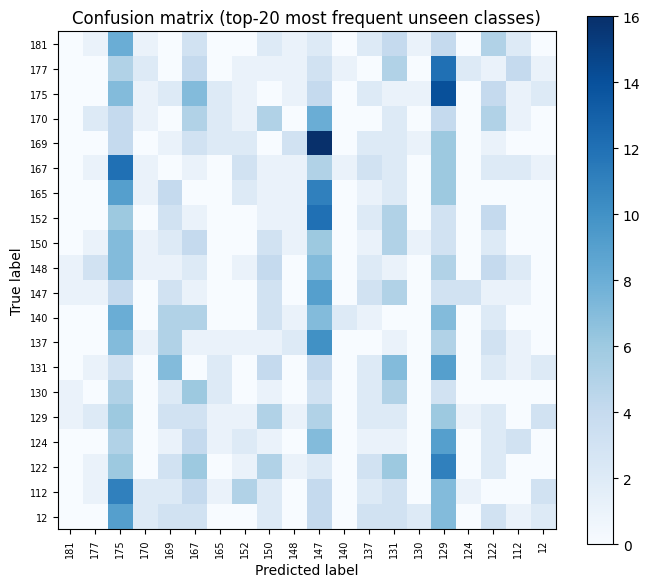

In [ ]:
#confusion matrix
from sklearn.metrics import confusion_matrix

classes, counts = np.unique(y_unseenNP, return_counts=True)
top20 = classes[np.argsort(counts)[-20:]]

mask = np.isin(y_unseenNP, top20)
y_true20 = y_unseenNP[mask]
y_hat20 = y_pred[mask]

cm = confusion_matrix(y_true20, y_hat20, labels=top20)

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(len(top20)), top20, rotation=90, fontsize=7)
plt.yticks(range(len(top20)), top20, fontsize=7)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (top-20 most frequent unseen classes)")
plt.tight_layout()
plt.show()

In [15]:
#per class accuracy
classes = np.unique(y_unseenNP)
classes_acc = [
    (y_pred[y_unseenNP == c] == c).mean()
    for c in classes
]
print(f"Per-class accuracy: {np.mean(classes_acc)} +- {np.std(classes_acc)}")

Per-class accuracy: 0.0024281078661743316 +- 0.008185438488151635


In [ ]:
''' 
This indicates that while zero-shot inference is viable, 
improved alignment between EEG and semantic spaces would help, 
motivates addition of orthogonal Procrustes alignment.
'''

' \nEEG embeddings were not trained to align with semantics\nDifferent classes overlap heavily in EEG space\nPCA preserves variance, not discriminability\nCosine similarity is applied to a misaligned space\n\nThis is exactly what motivates the advanced model.\n'

## Advanced model development: Prototype based Zero-Shot Learning with Orthogonal Procrustes Alignment

In [ ]:
import numpy as np

y_all_np = y_all.reshape(-1).astype(int)         
T_all_np = T_all.numpy() if hasattr(T_all, "numpy") else np.asarray(T_all)

all_classes = np.unique(y_all_np)

semantic_proto_all = {}
for c in all_classes:
    idx = np.where(y_all_np == c)[0]
    semantic_proto_all[c] = T_all_np[idx].mean(axis=0)


proto_labels_all = np.array(sorted(semantic_proto_all.keys()), dtype=int)
proto_matrix_all = np.stack([semantic_proto_all[c] for c in proto_labels_all], axis=0)


label_to_row = {c: i for i, c in enumerate(proto_labels_all)}


In [ ]:
def l2_normalize(x, axis=-1, eps=1e-12):
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (n + eps)

class ProcrustesRefiner:
    def __init__(self, center=True, temperature=1.0):
        self.center = center
        self.temperature = temperature
        self.mu_x = None
        self.mu_y = None
        self.W = None

    def fit(self, X, y, proto_matrix_all, proto_labels_all, label_to_row):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).reshape(-1).astype(int)

        Y = np.stack([proto_matrix_all[label_to_row[int(yy)]] for yy in y], axis=0).astype(np.float64)

        if self.center:
            self.mu_x = X.mean(axis=0, keepdims=True)
            self.mu_y = Y.mean(axis=0, keepdims=True)
            Xc = X - self.mu_x
            Yc = Y - self.mu_y
        else:
            self.mu_x = np.zeros((1, X.shape[1]))
            self.mu_y = np.zeros((1, Y.shape[1]))
            Xc, Yc = X, Y

        #closed form orthogonal map
        M = Xc.T @ Yc
        U, _, Vt = np.linalg.svd(M, full_matrices=False)
        self.W = U @ Vt
        return self

    def transform_X(self, X):
        X = np.asarray(X, dtype=np.float64)
        Z = (X - self.mu_x) @ self.W
        return l2_normalize(Z, axis=1)

    def transform_protos(self, proto_matrix_all):
        P = np.asarray(proto_matrix_all, dtype=np.float64)
        Pz = P - self.mu_y
        return l2_normalize(Pz, axis=1)

    def predict_unseen(self, X_test, proto_matrix_all, unseen_class_ids, proto_labels_all, label_to_row, topk=1):
        Zx = self.transform_X(X_test)
        Pn = self.transform_protos(proto_matrix_all)

        unseen_rows = np.array([label_to_row[int(c)] for c in unseen_class_ids], dtype=int)
        sims = (Zx @ Pn[unseen_rows].T) / float(self.temperature)

        idx = np.argpartition(-sims, kth=min(topk, sims.shape[1]-1), axis=1)[:, :topk]
        row = np.arange(sims.shape[0])[:, None]
        idx_sorted = idx[row, np.argsort(-sims[row, idx], axis=1)]

        pred_rows = unseen_rows[idx_sorted]
        preds = proto_labels_all[pred_rows]
        return preds, sims


In [ ]:
y_seen_np = y_seen.numpy().reshape(-1).astype(int)
y_unseen_np = y_unseen.numpy().reshape(-1).astype(int)

unseen_classes = np.unique(y_unseen_np)

ref = ProcrustesRefiner(center=True, temperature=1.0)
ref.fit(X_seen_512, y_seen_np, proto_matrix_all, proto_labels_all, label_to_row)

pred_top1, sims = ref.predict_unseen(
    X_test,
    proto_matrix_all,
    unseen_classes,
    proto_labels_all,
    label_to_row,
    topk=1
)

y_pred = pred_top1[:, 0]
class_labels = np.array(unseen_classes)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_unseen_np, y_pred)
print(f"ZSL Procrustes (A+B) accuracy: {acc:.4f}")


ZSL Procrustes (A+B) accuracy: 0.0083


In [20]:

def compute_topk_accuracy(sims, y_true, class_labels, k):
    sims = np.asarray(sims)
    y_true = np.asarray(y_true).reshape(-1)
    class_labels = np.asarray(class_labels)

    topk_idx = np.argpartition(sims, -k, axis=1)[:, -k:]
    row = np.arange(sims.shape[0])[:, None]
    topk_idx = topk_idx[row, np.argsort(-sims[row, topk_idx], axis=1)]
    topk_preds = class_labels[topk_idx]
    return np.mean((topk_preds == y_true[:, None]).any(axis=1))



In [21]:
top1 = compute_topk_accuracy(sims, y_unseen_np, class_labels, k=1)
top5 = compute_topk_accuracy(sims, y_unseen_np, class_labels, k=5)

print(f"Top-1 accuracy: {top1:.4f}")
print(f"Top-5 accuracy: {top5:.4f}")


Top-1 accuracy: 0.0083
Top-5 accuracy: 0.0375


## Evaluation (Visuals & Result Presentation)

In [ ]:
#bootstrap CI + bar plot

def topk_from_sims(sims, class_labels, k=5):
    sims = np.asarray(sims)
    class_labels = np.asarray(class_labels)
    k = int(k)
    topk_idx = np.argpartition(sims, -k, axis=1)[:, -k:]
    row = np.arange(sims.shape[0])[:, None]
    topk_idx = topk_idx[row, np.argsort(-sims[row, topk_idx], axis=1)]
    return class_labels[topk_idx]  

def topk_acc(sims, y_true, class_labels, k=5):
    topk_preds = topk_from_sims(sims, class_labels, k=k)
    y_true = np.asarray(y_true).reshape(-1)
    return np.mean((topk_preds == y_true[:, None]).any(axis=1))

def bootstrap_topk_ci(sims, y_true, class_labels, k=5, n_boot=500, seed=0):
    rng = np.random.default_rng(seed)
    sims = np.asarray(sims)
    y_true = np.asarray(y_true).reshape(-1)
    n = sims.shape[0]
    vals = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        vals[b] = topk_acc(sims[idx], y_true[idx], class_labels, k=k)
    mean = vals.mean()
    std = vals.std(ddof=1)
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return mean, std, (lo, hi)

def compare_models_barplot(y_true, class_labels, sims_base=None, sims_adv=None):
    labels = []
    means = []
    cis = []

    def add(name, sims, k):
        m, s, (lo, hi) = bootstrap_topk_ci(sims, y_true, class_labels, k=k)
        labels.append(f"{name} Top-{k}")
        means.append(m)
        cis.append((lo, hi))

    if sims_base is not None:
        add("Baseline", sims_base, 1); add("Baseline", sims_base, 5)
    if sims_adv is not None:
        add("Procrustes", sims_adv, 1); add("Procrustes", sims_adv, 5)

    x = np.arange(len(labels))
    y = np.array(means)
    yerr = np.array([[y[i]-cis[i][0] for i in range(len(cis))],
                     [cis[i][1]-y[i] for i in range(len(cis))]])

    plt.figure(figsize=(9, 4))
    plt.bar(x, y, yerr=yerr, capsize=4)
    plt.xticks(x, labels, rotation=20, ha='right')
    plt.ylabel("Accuracy")
    plt.title("Top-k accuracy with 95% bootstrap CI (unseen test set)")
    plt.tight_layout()
    plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/bar_plot.png", dpi=300, bbox_inches="tight")
    plt.show()


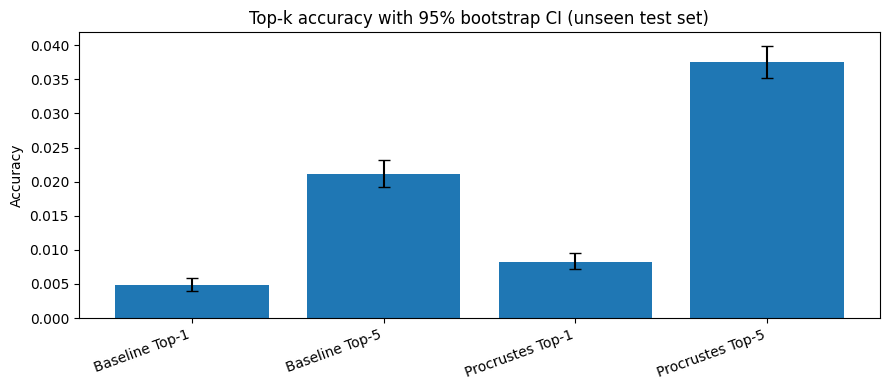

Baseline Top-1, Top-5: 0.0048951048951048955 0.021212121212121213
Procrustes Top-1, Top-5: 0.008251748251748252 0.03752913752913753


In [ ]:
y_true = y_unseen.numpy().reshape(-1).astype(int)
class_labels = np.array(unseen_classes, dtype=int)

compare_models_barplot(y_true, class_labels, S, sims)
print("Baseline Top-1, Top-5:", topk_acc(S, y_true, class_labels, 1), topk_acc(S, y_true, class_labels, 5))
print("Procrustes Top-1, Top-5:", topk_acc(sims, y_true, class_labels, 1), topk_acc(sims, y_true, class_labels, 5))


In [ ]:
#Confusion matrix
import seaborn as sns

def confusion_matrix_top1(sims, y_true, class_labels, max_classes=20, vmax=20, savepath=None):
    y_pred = class_labels[np.argmax(sims, axis=1)]
    y_true = np.asarray(y_true).reshape(-1)
    uniq, cnt = np.unique(y_true, return_counts=True)
    order = uniq[np.argsort(-cnt)]
    show = order[:min(max_classes, len(order))]

    cm = confusion_matrix(y_true, y_pred, labels=show)
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, cmap='Blues', square=True, vmin=0, vmax=vmax)
    ax.set_title(f"Top-1 Confusion Matrix (top {len(show)} frequent unseen classes)")
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    plt.tight_layout()
    
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    plt.show()
    return y_pred

def top_confusions(cm, labels, top_n=15):
    pairs = []
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j and cm[i, j] > 0:
                pairs.append((cm[i, j], labels[i], labels[j]))
    pairs.sort(reverse=True)
    return pairs[:top_n]


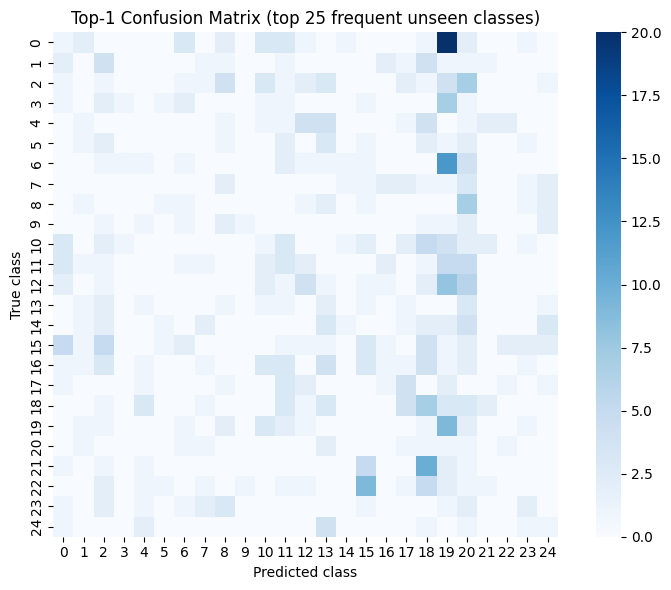

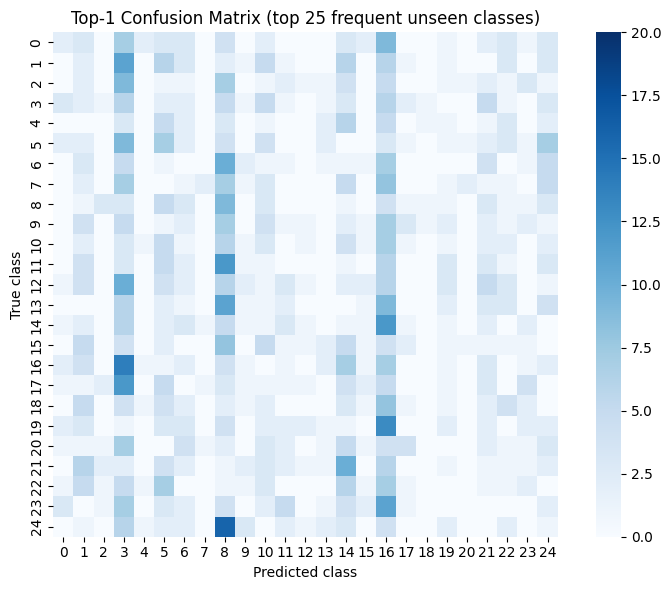

In [ ]:
y_pred_adv = confusion_matrix_top1(sims, y_true, class_labels, max_classes=25, savepath="/Users/ankithrangan/Desktop/Coursework charts/confusion_advanced.png")
y_pred_base = confusion_matrix_top1(S, y_true, class_labels, max_classes=25)

In [ ]:
#best/worse case bar charts (failure cases)

def per_class_accuracy(sims, y_true, class_labels):
    y_pred = class_labels[np.argmax(sims, axis=1)]
    y_true = np.asarray(y_true).reshape(-1)
    acc = {}
    for c in np.unique(y_true):
        idx = (y_true == c)
        acc[c] = np.mean(y_pred[idx] == c)
    return acc

def plot_best_worst_classes(acc_dict, title, n=10):
    items = sorted(acc_dict.items(), key=lambda x: x[1])
    worst = items[:n]
    best = items[-n:]

    def _plot(items, subtitle):
        cls = [str(c) for c, _ in items]
        vals = [v for _, v in items]
        plt.figure(figsize=(9, 3))
        plt.bar(cls, vals)
        plt.xticks(rotation=45, ha='right')
        plt.ylim(0, max(vals + [0.01])*1.2)
        plt.title(f"{title} — {subtitle}")
        plt.ylabel("Top-1 accuracy")
        plt.tight_layout()
        plt.show()

    _plot(worst, "Worst classes")
    _plot(best, "Best classes")


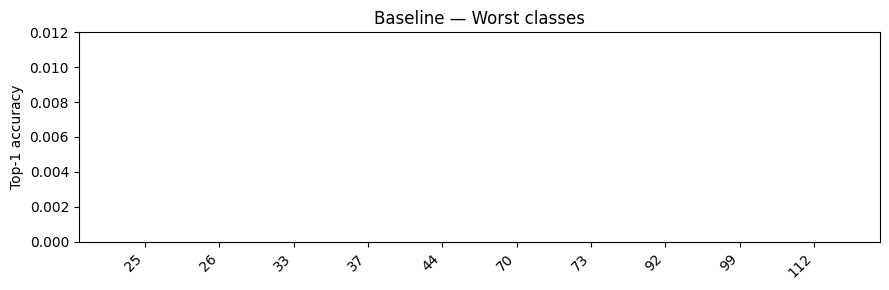

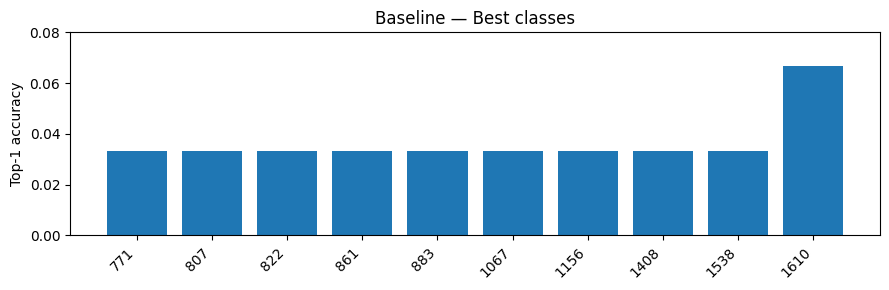

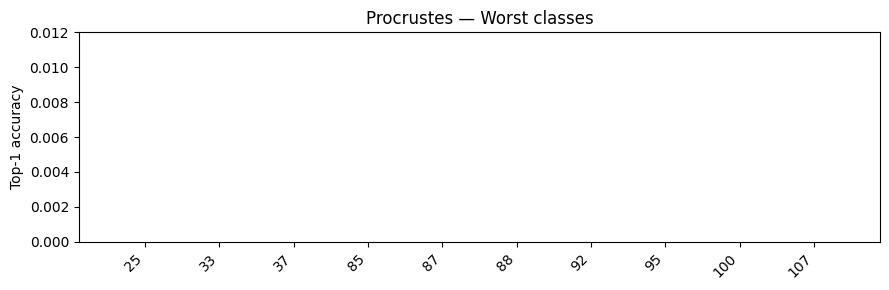

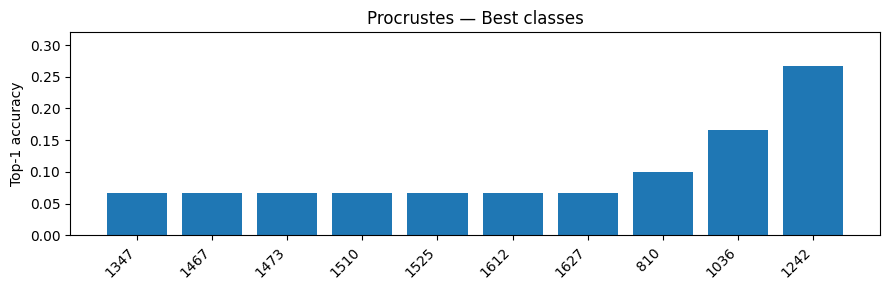

In [ ]:
acc_base = per_class_accuracy(S, y_true, class_labels)
acc_adv  = per_class_accuracy(sims,  y_true, class_labels)

plot_best_worst_classes(acc_base, "Baseline", n=10)
plot_best_worst_classes(acc_adv,  "Procrustes", n=10)


In [ ]:
#semantic error severity plot

from sklearn.metrics.pairwise import cosine_similarity

def semantic_error_analysis(sims, y_true, class_labels, proto_unseen, ylim=None, savepath=None):
    y_true = np.asarray(y_true).reshape(-1)
    class_labels = np.asarray(class_labels)
    proto_unseen = np.asarray(proto_unseen)

    pred_idx = np.argmax(sims, axis=1)
    y_pred = class_labels[pred_idx]

    label_to_col = {int(c): i for i, c in enumerate(class_labels)}

    true_cols = np.array([label_to_col[int(c)] for c in y_true], dtype=int)
    pred_cols = pred_idx

    Pn = proto_unseen / (np.linalg.norm(proto_unseen, axis=1, keepdims=True) + 1e-8)
    proto_cos = (Pn @ Pn.T) 

    sev = proto_cos[true_cols, pred_cols] 
    correct = (y_pred == y_true)

    plt.figure(figsize=(7, 3))
    plt.hist(sev[~correct], bins=30, alpha=0.8)
    plt.title("Semantic similarity between TRUE and PREDICTED prototypes (errors only)")
    plt.xlabel("cos(true prototype, predicted prototype)")
    plt.ylabel("count")

    if ylim is not None:
        plt.ylim(0, ylim)
    
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')    

    plt.tight_layout()
    plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/semantic_error_severity.png", dpi=300, bbox_inches="tight")
    plt.show()

    return sev, correct


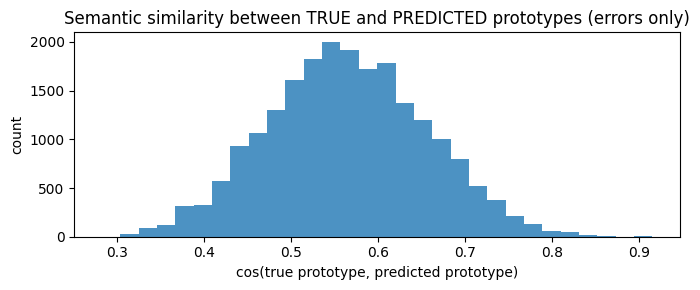

Mean semantic similarity on errors: 0.5641768051201691


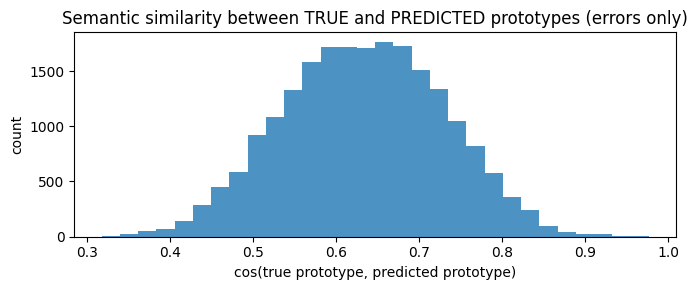

Mean semantic similarity on errors: 0.6332197060454178


In [ ]:
sev_base, corr_base = semantic_error_analysis(S, y_true, class_labels, proto_matrix, savepath="/Users/ankithrangan/Desktop/Coursework charts/semantic_error_baseline.png")
sev_adv,  corr_adv  = semantic_error_analysis(sims,  y_true, class_labels, proto_matrix, savepath="/Users/ankithrangan/Desktop/Coursework charts/semantic_error_advanced.png")

In [ ]:
#Hubness failure
def hubness_plot(sims, class_labels, title, ymax=None, savepath=None):
    y_pred = np.asarray(class_labels)[np.argmax(sims, axis=1)]
    uniq, cnt = np.unique(y_pred, return_counts=True)
    order = np.argsort(-cnt)[:20]  


    plt.figure(figsize=(9, 3))
    plt.bar([str(uniq[i]) for i in order], cnt[order])
    plt.xticks(rotation=45, ha='right')
    plt.title(f"{title}: Top-1 predicted class frequency (hubness)")
    plt.ylabel("# predictions")
    plt.tight_layout()

    if ymax is not None:
        plt.ylim(0, ymax)
    
    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')    

    plt.show()

    return cnt 


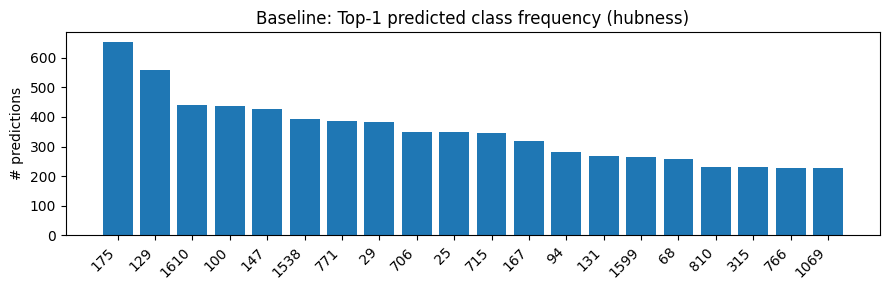

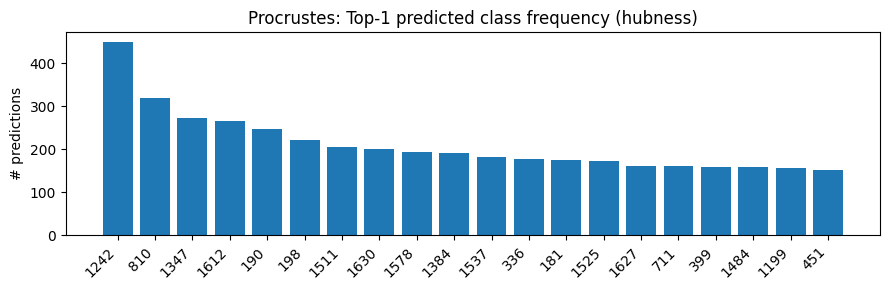

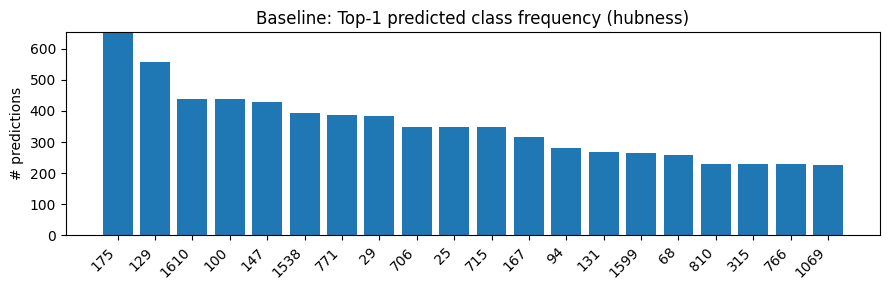

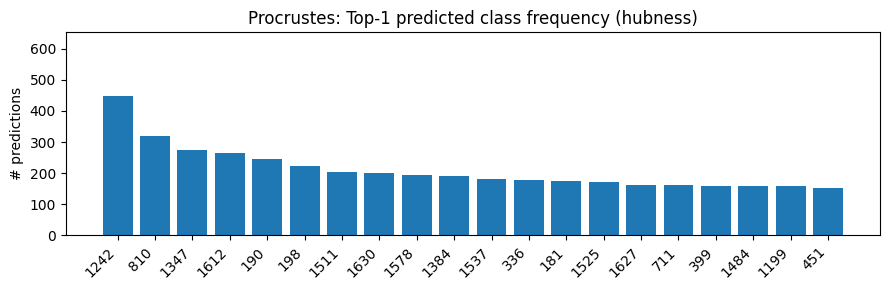

array([ 46, 101,  20,  16,  25,  38, 131,  16,   8,  67,  59, 114, 139,
       105,  59,  13,  32,  15,  77,  44,  10,  29,  16,  19,  41,  10,
        71,  68,  14,  31,  11,  58,  23,  58,   9,  51,  84,  71,  78,
        23,  53,  97,  18,  56, 176, 247, 222,  10, 108,  14,   8,  33,
        45,  94,  59, 145,  87,  33,  21, 104, 128,  36,  47,  45,  90,
        86,  45, 113,  45,  43,  33,  86,  23,  12,  32, 178,  44,  30,
        40,  36,  63, 111,  91,  23,  89, 159,  55,   5,  72,  70,  31,
       105, 151,  64,  19,  10,  23,  48,  60,   9,  48,  72, 126,  11,
        75,  46, 148, 122,  23, 144,  12,  60,  25, 121,  27,  32,  48,
        26, 124,   7,  27,  35, 146,  52,  74,  35,  51, 128,  47,  10,
        64,  44,  12,  30,  75,  67,  46, 115, 162,  25,  12,  25,  31,
        36,  24,  34,  75, 139,  31,  25,  48,  71,  23,  46,  55,  27,
        99, 123,  93,  55,  30,  29,  82,  54,  74,  22,  54,  51, 318,
        22,  52,  42,   5,  60,  63, 103,  19,  45,  13,  20,  6

In [ ]:
cnt_base = hubness_plot(S, class_labels, "Baseline")      
cnt_adv  = hubness_plot(sims,  class_labels, "Procrustes")    

ymax = max(cnt_base.max(), cnt_adv.max())

hubness_plot(S, class_labels, "Baseline", ymax=ymax, savepath="/Users/ankithrangan/Desktop/Coursework charts/hubness_baseline.png")
hubness_plot(sims,  class_labels, "Procrustes", ymax=ymax, savepath="/Users/ankithrangan/Desktop/Coursework charts/hubness_advanced.png")


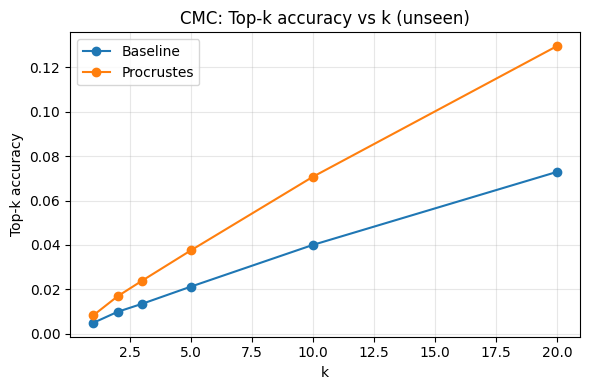

In [ ]:
#CMC curve
def cmc_curve(sims, y_true, class_labels, ks=(1,2,3,5,10,20)):
    accs = []
    for k in ks:
        accs.append(topk_acc(sims, y_true, class_labels, k=k))
    return np.array(accs)

def plot_cmc(sims_base, sims_adv, y_true, class_labels, ks=(1,2,3,5,10,20)):
    a = cmc_curve(sims_base, y_true, class_labels, ks=ks)
    b = cmc_curve(sims_adv,  y_true, class_labels, ks=ks)
    plt.figure(figsize=(6,4))
    plt.plot(ks, a, marker='o', label='Baseline')
    plt.plot(ks, b, marker='o', label='Procrustes')
    plt.xlabel("k")
    plt.ylabel("Top-k accuracy")
    plt.title("CMC: Top-k accuracy vs k (unseen)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/CMC_curve.png", dpi=300, bbox_inches="tight")
    plt.show()

plot_cmc(S, sims, y_true, class_labels)


In [ ]:
#t-SNE plots

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def tsne_plot_embeddings(Z, y, title, max_points=2000, seed=0, ax=None):
    Z = np.asarray(Z)
    y = np.asarray(y).reshape(-1)

    if Z.shape[0] > max_points:
        rng = np.random.default_rng(seed)
        idx = rng.choice(Z.shape[0], size=max_points, replace=False)
        Z = Z[idx]; y = y[idx]

    Z2 = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=seed
    ).fit_transform(Z)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))

    ax.scatter(Z2[:,0], Z2[:,1], c=y, s=8, cmap="tab20", alpha=0.8)
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

    return ax  


def set_same_axes(ax1, ax2):
    x1, x2 = ax1.get_xlim(), ax2.get_xlim()
    y1, y2 = ax1.get_ylim(), ax2.get_ylim()
    xmin, xmax = min(x1[0], x2[0]), max(x1[1], x2[1])
    ymin, ymax = min(y1[0], y2[0]), max(y1[1], y2[1])
    ax1.set_xlim(xmin, xmax); ax2.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax); ax2.set_ylim(ymin, ymax)


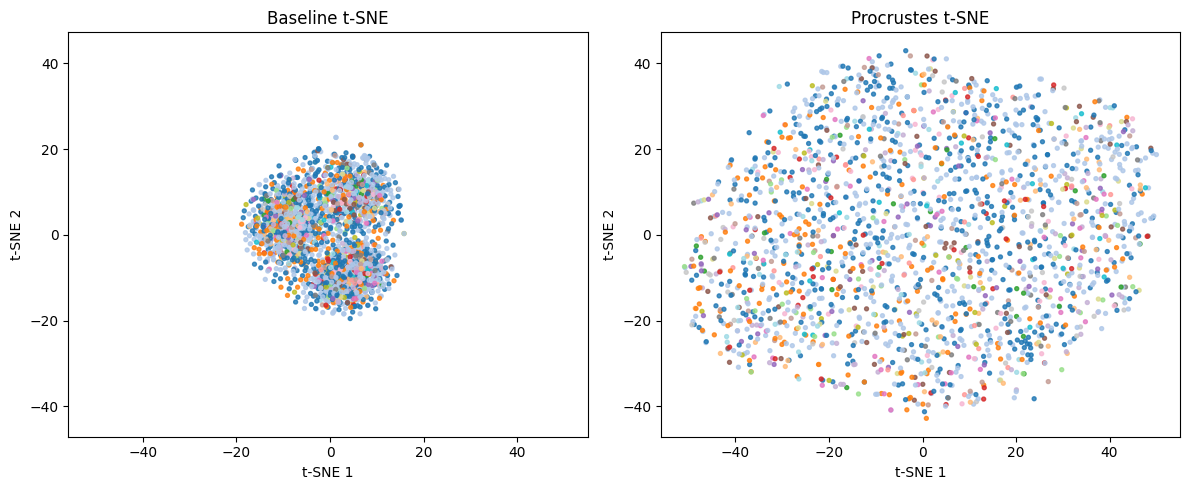

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1 = tsne_plot_embeddings(X_test, y_true, "Baseline t-SNE", seed=0, ax=ax1)
ax2 = tsne_plot_embeddings(sims,  y_true, "Procrustes t-SNE", seed=0, ax=ax2)

set_same_axes(ax1, ax2)

plt.tight_layout()
plt.savefig("/Users/ankithrangan/Desktop/Coursework charts/t-SNE.png", dpi=300, bbox_inches="tight")
plt.show()
